<a href="https://colab.research.google.com/github/peterbabulik/OllamaSociety-/blob/main/QantumClimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install cirq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

=== Quantum-Classical Climate Model ===

Generating initial climate state...

Testing model prediction...

Model Output Shape: (1, 10, 10, 3)
Represents: [batch, grid_size, grid_size, variables]


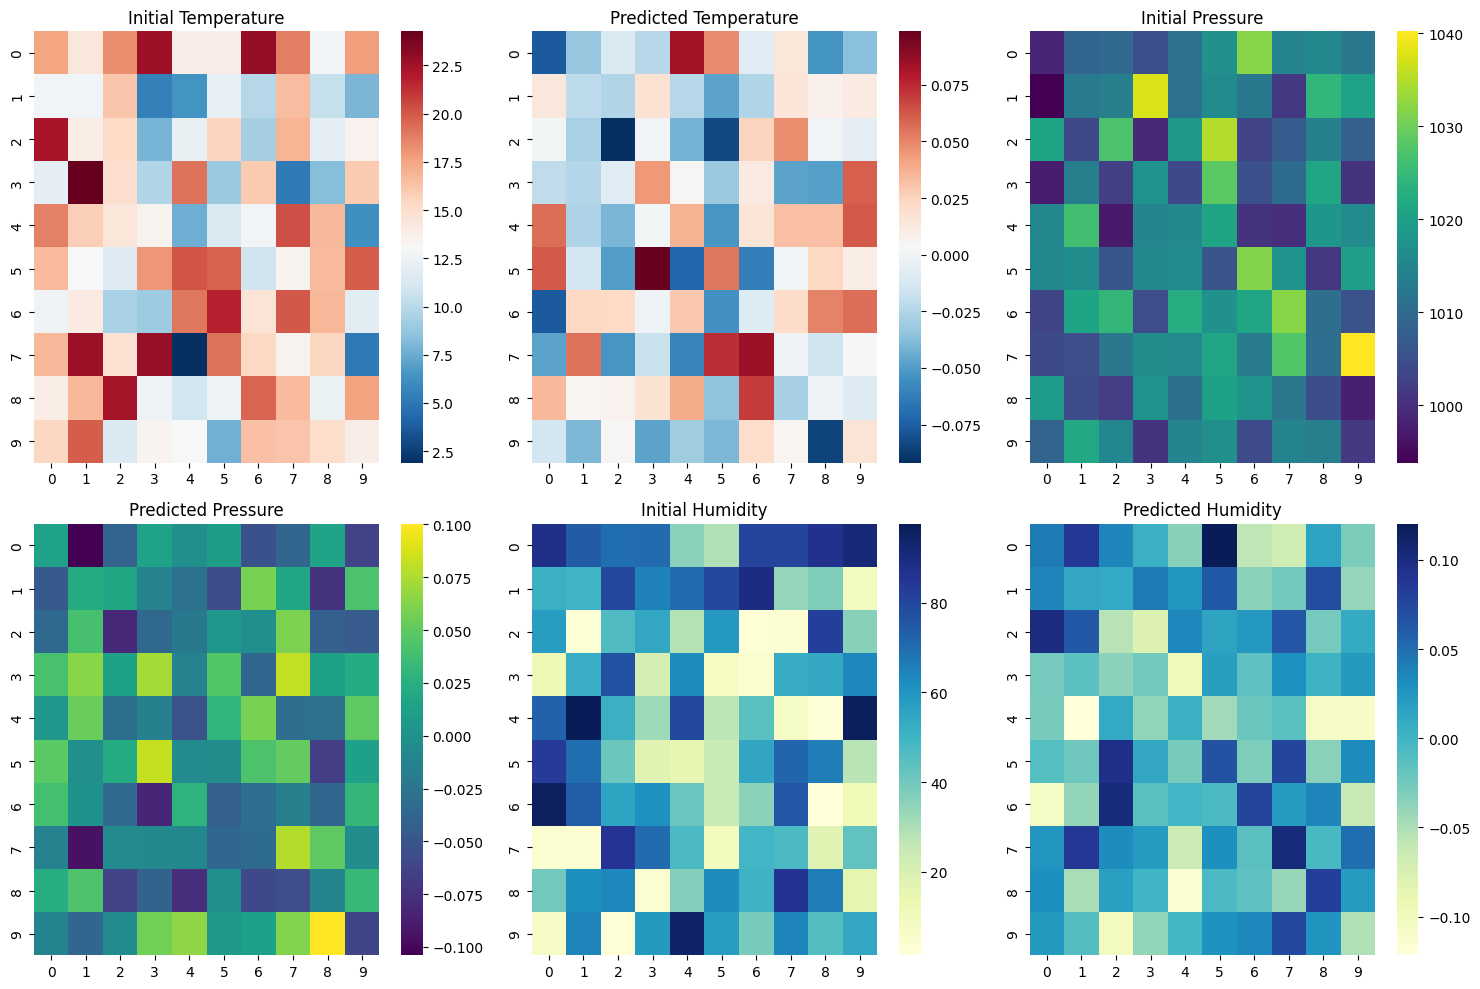

In [ ]:
import numpy as np
import cirq
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import List, Tuple
import seaborn as sns
from tqdm import tqdm

class QuantumClimateLayer(tf.keras.layers.Layer):
    """Quantum layer for processing climate variables"""
    def __init__(self, n_qubits: int, n_layers: int):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.qubits = cirq.LineQubit.range(n_qubits)
        self.simulator = cirq.Simulator()
        self.kernel_size = n_qubits * n_layers * 3  # 3 rotation gates per qubit

    def build(self, input_shape):
        # Initialize quantum parameters
        self.kernel = tf.Variable(
            initial_value=tf.random.normal(
                shape=(self.kernel_size,),
                mean=0,
                stddev=0.1
            ),
            trainable=True,
            name='quantum_kernel'
        )

    def get_quantum_circuit(self, inputs, params):
        """Create quantum circuit with numpy values"""
        circuit = cirq.Circuit()

        # Convert inputs and params to numpy arrays
        input_values = np.array(inputs).flatten()
        param_values = np.array(params).flatten()

        # Initial state preparation
        for i, qubit in enumerate(self.qubits):
            if i < len(input_values):
                angle = float(input_values[i])
                circuit.append(cirq.ry(angle)(qubit))

        # Variational quantum layers
        param_idx = 0
        for layer in range(self.n_layers):
            # Rotation gates
            for i, qubit in enumerate(self.qubits):
                if param_idx + 2 < len(param_values):
                    rx_angle = float(param_values[param_idx])
                    ry_angle = float(param_values[param_idx + 1])
                    rz_angle = float(param_values[param_idx + 2])

                    circuit.append([
                        cirq.rx(rx_angle)(qubit),
                        cirq.ry(ry_angle)(qubit),
                        cirq.rz(rz_angle)(qubit)
                    ])
                    param_idx += 3

            # Entangling layer
            for i in range(self.n_qubits - 1):
                circuit.append(cirq.CNOT(self.qubits[i], self.qubits[i + 1]))

        return circuit

    def quantum_forward(self, inputs, params):
        """Execute quantum circuit and return results"""
        try:
            # Create and simulate circuit
            circuit = self.get_quantum_circuit(inputs, params)
            result = self.simulator.simulate(circuit)
            state_vector = result.final_state_vector

            # Convert to real values
            features = np.concatenate([
                np.real(state_vector),
                np.imag(state_vector)
            ]).astype(np.float32)

            return features

        except Exception as e:
            print(f"Quantum simulation error: {str(e)}")
            return np.zeros(2 * 2**self.n_qubits, dtype=np.float32)

    def call(self, inputs):
        # Process batch
        return tf.map_fn(
            lambda x: tf.py_function(
                func=lambda inp: self.quantum_forward(inp, self.kernel),
                inp=[x],
                Tout=tf.float32
            ),
            inputs,
            fn_output_signature=tf.float32
        )

class ClimateSystem:
    """Simple climate system simulation"""
    def __init__(self, grid_size: int = 10):
        self.grid_size = grid_size
        self.temperature = np.zeros((grid_size, grid_size))
        self.pressure = np.zeros((grid_size, grid_size))
        self.humidity = np.zeros((grid_size, grid_size))

    def initialize_random(self):
        """Initialize with realistic climate values"""
        self.temperature = np.random.normal(15, 5, (self.grid_size, self.grid_size))
        self.pressure = np.random.normal(1013, 10, (self.grid_size, self.grid_size))
        self.humidity = np.random.uniform(0, 100, (self.grid_size, self.grid_size))

    def step(self, dt: float = 0.1):
        """Simulate one time step"""
        # Temperature diffusion
        self.temperature += dt * np.random.normal(0, 0.1, (self.grid_size, self.grid_size))

        # Pressure changes based on temperature
        self.pressure += dt * (self.temperature - 15) * 0.1

        # Humidity changes
        self.humidity += dt * np.random.normal(0, 5, (self.grid_size, self.grid_size))
        self.humidity = np.clip(self.humidity, 0, 100)

class QuantumClimateModel(tf.keras.Model):
    """Quantum-enhanced climate prediction model"""
    def __init__(self, grid_size: int, n_qubits: int):
        super().__init__()
        self.grid_size = grid_size
        self.n_qubits = n_qubits

        # Classical encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(32, activation='relu')
        ])

        # Quantum processing
        self.quantum_layer = QuantumClimateLayer(n_qubits=n_qubits, n_layers=2)

        # Classical decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(grid_size * grid_size * 3)  # 3 climate variables
        ])

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.quantum_layer(x)
        x = self.decoder(x)
        return tf.reshape(x, [-1, self.grid_size, self.grid_size, 3])

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Initialize system
print("=== Quantum-Classical Climate Model ===")

grid_size = 10
n_qubits = 6
climate_system = ClimateSystem(grid_size=grid_size)
model = QuantumClimateModel(grid_size=grid_size, n_qubits=n_qubits)

# Generate sample data
print("\nGenerating initial climate state...")
climate_system.initialize_random()
initial_state = np.stack([
    climate_system.temperature,
    climate_system.pressure,
    climate_system.humidity
], axis=-1)

# Normalize input data
initial_state_norm = (initial_state - np.mean(initial_state, axis=(0, 1))) / np.std(initial_state, axis=(0, 1))

# Make prediction
print("\nTesting model prediction...")
input_data = tf.convert_to_tensor([initial_state_norm.reshape(-1)], dtype=tf.float32)
prediction = model(input_data)

print("\nModel Output Shape:", prediction.shape)
print("Represents: [batch, grid_size, grid_size, variables]")

# Create visualization
plt.figure(figsize=(15, 10))

# Plot temperature
plt.subplot(231)
sns.heatmap(climate_system.temperature, cmap='RdBu_r')
plt.title('Initial Temperature')

plt.subplot(232)
sns.heatmap(prediction[0, :, :, 0], cmap='RdBu_r')
plt.title('Predicted Temperature')

# Plot pressure
plt.subplot(233)
sns.heatmap(climate_system.pressure, cmap='viridis')
plt.title('Initial Pressure')

plt.subplot(234)
sns.heatmap(prediction[0, :, :, 1], cmap='viridis')
plt.title('Predicted Pressure')

# Plot humidity
plt.subplot(235)
sns.heatmap(climate_system.humidity, cmap='YlGnBu')
plt.title('Initial Humidity')

plt.subplot(236)
sns.heatmap(prediction[0, :, :, 2], cmap='YlGnBu')
plt.title('Predicted Humidity')

plt.tight_layout()
plt.show()

# Print model summary
print("\nQuantum Circuit Summary:")
print(f"Number of qubits: {n_qubits}")
print(f"Circuit depth: {model.quantum_layer.n_layers}")
print(f"Quantum parameters: {model.quantum_layer.kernel_size}")

# Example quantum circuit visualization
example_circuit = model.quantum_layer.get_quantum_circuit(
    np.zeros(32),  # Example input
    np.random.normal(0, 0.1, model.quantum_layer.kernel_size)  # Example parameters
)
print("\nExample Quantum Circuit:")
print(example_circuit)